In [1]:
import numpy as np
import time
from pyDOE import lhs
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import shutil
import pickle
import math
import scipy.io

import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # CPU:-1; GPU0: 1; GPU1: 0;
np.random.seed(1111)
tf.compat.v1.set_random_seed(1111)

2022-10-23 09:03:46.451664: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
misfit = []
misfit1 = []
class DeepHPM:
    # Initialize the class
    def __init__(self, Collo, snap1, snap2, vp, uv_layers, lb, ub, ExistModel=0, modelDir=''):

        self.count = 0
        self.vp = vp

        
        self.lb = lb
        self.ub = ub
        self.loss_f_rec = []
        self.loss_snap_rec=[]
        self.loss_rec=[]
        self.train_loss=[]
   

        # Collocation point
        self.x_c = Collo[:, 0:1]
        self.y_c = Collo[:, 1:2]
        self.t_c = Collo[:, 2:3]

        self.x_snap1 = snap1[:, 0:1]
        self.y_snap1 = snap1[:, 1:2]
        self.t_snap1 = snap1[:, 2:3]
        self.u_snap1 = snap1[:, 3:4]
        
        self.x_snap2 = snap2[:, 0:1]
        self.y_snap2 = snap2[:, 1:2]
        self.t_snap2 = snap2[:, 2:3]
        self.u_snap2 = snap2[:, 3:4]
        
       
        # Define layers
        self.uv_layers = uv_layers

        # Initialize NNs
        if ExistModel== 0 :
            self.uv_weights, self.uv_biases = self.initialize_NN(self.uv_layers)
        else:
            self.uv_weights, self.uv_biases = self.load_NN(modelDir, self.uv_layers)
        # tf placeholders
        self.learning_rate = tf.placeholder(tf.float32, shape=[])
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x_c.shape[1]])    # Point for postprocessing
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y_c.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t_c.shape[1]])

        self.x_c_tf = tf.placeholder(tf.float32, shape=[None, self.x_c.shape[1]])
        self.y_c_tf = tf.placeholder(tf.float32, shape=[None, self.y_c.shape[1]])
        self.t_c_tf = tf.placeholder(tf.float32, shape=[None, self.t_c.shape[1]])

        self.x_snap1_tf = tf.placeholder(tf.float32, shape=[None, self.x_snap1.shape[1]])
        self.y_snap1_tf = tf.placeholder(tf.float32, shape=[None, self.y_snap1.shape[1]])
        self.t_snap1_tf = tf.placeholder(tf.float32, shape=[None, self.t_snap1.shape[1]])
        self.u_snap1_tf = tf.placeholder(tf.float32, shape=[None, self.u_snap1.shape[1]])

        self.x_snap2_tf = tf.placeholder(tf.float32, shape=[None, self.x_snap2.shape[1]])
        self.y_snap2_tf = tf.placeholder(tf.float32, shape=[None, self.y_snap2.shape[1]])
        self.t_snap2_tf = tf.placeholder(tf.float32, shape=[None, self.t_snap2.shape[1]])
        self.u_snap2_tf = tf.placeholder(tf.float32, shape=[None, self.u_snap2.shape[1]])
 
        self.u_pred = self.net_uv(self.x_tf, self.y_tf, self.t_tf)
        self.u_snap2_pred  = self.net_uv(self.x_snap2_tf, self.y_snap2_tf, self.t_snap2_tf)
        self.u_snap1_pred  = self.net_uv(self.x_snap1_tf, self.y_snap1_tf, self.t_snap1_tf)
  
      
        self.f_pred_u = self.net_f_sig(self.x_c_tf, self.y_c_tf, self.t_c_tf)

        self.loss_f = tf.reduce_mean(tf.square(self.f_pred_u)) 
    
        self.loss_snap = tf.reduce_mean(tf.square(self.u_snap1_pred - self.u_snap1_tf)) \
                         + tf.reduce_mean(tf.square(self.u_snap2_pred - self.u_snap2_tf))

        self.loss = self.loss_snap + 1e-4*self.loss_f
        #self.loss = self.loss_snap + 1e-3*self.loss_f #for the second training
        #self.loss = self.loss_snap + 1e-1*self.loss_f #for the third training

        # Optimizer for solution
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                var_list=self.uv_weights + self.uv_biases,
                                                                method='L-BFGS-B',
                                                                options={'maxiter': 20000,
                                                                         'maxfun': 20000,
                                                                         'maxcor': 50,
                                                                         'maxls': 50,
                                                                         'ftol': 1 * np.finfo(float).eps})

        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 0.001
        #starter_learning_rate = 0.0001 #for the second training
        #starter_learning_rate = 0.00001 #for the third training
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                        10000, 0.9, staircase=False)
        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss,
                                                          var_list=self.uv_weights + self.uv_biases)

        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)


    def save_NN(self, fileDir):
        uv_weights = self.sess.run(self.uv_weights)
        uv_biases = self.sess.run(self.uv_biases)
        with open(fileDir, 'wb') as f:
            # pickle.dump([np.array(uv_weights), np.array(uv_biases)], f)
            pickle.dump([uv_weights, uv_biases], f)
            print("Save NN parameters successfully...")

    def load_NN(self, fileDir, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        with open(fileDir, 'rb') as f:
            uv_weights, uv_biases = pickle.load(f)
            # print(len(uv_weights))
            # print(np.shape(uv_weights))
            # print(num_layers)

            # Stored model must has the same # of layers
            assert num_layers == (len(uv_weights)+1)

            for num in range(0, num_layers - 1):
                W = tf.Variable(uv_weights[num])
                b = tf.Variable(uv_biases[num])
                weights.append(W)
                biases.append(b)
                print("Load NN parameters successfully...")
        return weights, biases

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        # H = X
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.sin(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_uv(self, x, y, t):
        # This NN return sigma_phi
        u = self.neural_net(tf.concat([x, y, t], 1), self.uv_weights, self.uv_biases)
        u = u[:, 0:1]
        #ut = tf.gradients(u, t)[0]
        return u 

    def net_f_sig(self, x, y, t):
        
        vp =self.vp         
        u = self.net_uv(x, y, t)
        ut = tf.gradients(u, t)[0]
        u_tt = tf.gradients(ut, t)[0]

        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]

        f_u = u_tt - vp*vp*(u_xx + u_yy)
        return f_u

    def callback(self, loss):
        self.count = self.count + 1
        print('{} th iterations, Loss: {}'.format(self.count, loss))
        self.train_loss.append(loss)

    def train(self, iter, batch_num):


        loss_f = []
        loss_snap = []
        loss = []

        # The collocation point is splited into partitions of batch_num，1 epoch for training
        for i in range(batch_num):
            col_num = self.x_c.shape[0]
            idx_start = int(i * col_num / batch_num)
            idx_end = int((i + 1) * col_num / batch_num)

            tf_dict = {self.x_c_tf: self.x_c[idx_start:idx_end,:], self.y_c_tf: self.y_c[idx_start:idx_end,:], self.t_c_tf: self.t_c[idx_start:idx_end,:],
                       self.x_snap1_tf: self.x_snap1, self.y_snap1_tf: self.y_snap1, self.t_snap1_tf: self.t_snap1, self.u_snap1_tf: self.u_snap1,
                       self.x_snap2_tf: self.x_snap2, self.y_snap2_tf: self.y_snap2, self.t_snap2_tf: self.t_snap2, self.u_snap2_tf: self.u_snap2}

            for it in range(iter):

                self.sess.run(self.train_op_Adam, tf_dict)

                # Print
                if it % 10 == 0:
                    loss_value = self.sess.run(self.loss, tf_dict)
                    loss_f_value = self.sess.run(self.loss_f, tf_dict)
                    loss_snap_value = self.sess.run(self.loss_snap, tf_dict)
                    print('It: %d, Loss: %.3e, %.3e, %.3e' %
                          (it, loss_value, loss_snap_value,loss_f_value))

                self.loss_f_rec.append(self.sess.run(self.loss_f, tf_dict))
                self.loss_snap_rec.append(self.sess.run(self.loss_snap, tf_dict))
                self.loss_rec.append(self.sess.run(self.loss, tf_dict))

        return self.loss, self.loss_snap, self.loss_f

    def train_bfgs(self, batch_num):
        # The collocation point is splited into partitions of batch_num
        for i in range(batch_num):
            col_num = self.x_c.shape[0]
            idx_start = int(i*col_num/batch_num)
            idx_end = int((i+1)*col_num/batch_num)
            tf_dict = {self.x_c_tf: self.x_c[idx_start:idx_end,:], self.y_c_tf: self.y_c[idx_start:idx_end,:], self.t_c_tf: self.t_c[idx_start:idx_end,:],
                       self.x_snap1_tf: self.x_snap1, self.y_snap1_tf: self.y_snap1, self.t_snap1_tf: self.t_snap1, self.u_snap1_tf: self.u_snap1,
                       self.x_snap2_tf: self.x_snap2, self.y_snap2_tf: self.y_snap2, self.t_snap2_tf: self.t_snap2, self.u_snap2_tf: self.u_snap2}

            self.optimizer.minimize(self.sess,
                                    feed_dict=tf_dict,
                                    fetches=[self.loss],
                                    loss_callback=self.callback)

    def predict(self, x_star, y_star, t_star):
        u_star = self.sess.run(self.u_pred, {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star})
        return u_star

    def probe(self, x_star, y_star, t_star):
        u_star = self.sess.run(self.u_pred, {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star})      
        return u_star
    
    def getloss(self):  # To be updated

        tf_dict = {self.x_c_tf: self.x_c, self.y_c_tf: self.y_c, self.t_c_tf: self.t_c,
                   self.x_snap1_tf: self.x_snap1, self.y_snap1_tf: self.y_snap1, self.t_snap1_tf: self.t_snap1, self.u_snap1_tf: self.u_snap1,
                   self.x_snap2_tf: self.x_snap2, self.y_snap2_tf: self.y_snap2, self.t_snap2_tf: self.t_snap2, self.u_snap2_tf: self.u_snap2}

        loss_f = self.sess.run(self.loss_f, tf_dict)
        loss_snap = self.sess.run(self.loss_snap, tf_dict)
        loss = self.sess.run(self.loss, tf_dict)
       
        return loss, loss_snap ,loss_f



2022-10-23 09:04:17.151608: I tensorflow/core/platform/cpu_feature_guard.cc:145] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
2022-10-23 09:04:17.175536: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2600000000 Hz
2022-10-23 09:04:17.180709: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e363621440 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-10-23 09:04:17.180726: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-10-23 09:04:17.181944: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-23 09:04:17.371523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:56:00.0
2022-10-23 09:04:17.3

Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...
Load NN parameters successfully...



2022-10-23 09:04:17.881151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1206] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-10-23 09:04:17.881181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1212]      0 
2022-10-23 09:04:17.881186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1225] 0:   N 
2022-10-23 09:04:17.882449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1351] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 22088 MB memory) -> physical GPU (device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:56:00.0, compute capability: 8.6)
2022-10-23 09:04:17.885271: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e375fe1f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-10-23 09:04:17.885291: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:56:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device




2022-10-23 09:04:23.584218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:56:00.0
2022-10-23 09:04:23.584342: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-10-23 09:04:23.584580: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-10-23 09:04:23.584597: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-10-23 09:04:23.584606: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2022-10-23 09:04:23.584615: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.11
2022-10-23 09:04:23.584623: I tensorflow/stream_executor/pla

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:56:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:GPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:GPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:GPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:GPU:0
Variable_1/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
Variable_2: (VariableV2): /job:localhost/replica:0/task:0/device:GPU:0
Variable_2/Assign: (Assign): /job:localhost/replica:0/task:0/device:GPU:0
Variable_2/read: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
Variable_3: (VariableV2): /job:localhost/re

ime/placer.cc:54] gradients_4/gradients_2/sub_6_grad/Sum_grad/Fill: (Fill): /job:localhost/replica:0/task:0/device:GPU:0
2022-10-23 09:04:23.777866: I tensorflow/core/common_runtime/placer.cc:54] gradients_4/gradients_2/sub_6_grad/Sum_grad/DynamicStitch: (DynamicStitch): /job:localhost/replica:0/task:0/device:GPU:0
2022-10-23 09:04:23.777875: I tensorflow/core/common_runtime/placer.cc:54] gradients_4/gradients_2/sub_6_grad/Sum_grad/Maximum: (Maximum): /job:localhost/replica:0/task:0/device:GPU:0
2022-10-23 09:04:23.777883: I tensorflow/core/common_runtime/placer.cc:54] gradients_4/gradients_2/sub_6_grad/Sum_grad/floordiv: (FloorDiv): /job:localhost/replica:0/task:0/device:GPU:0
2022-10-23 09:04:23.777894: I tensorflow/core/common_runtime/placer.cc:54] gradients_4/gradients_2/sub_6_grad/Sum_grad/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
2022-10-23 09:04:23.777905: I tensorflow/core/common_runtime/placer.cc:54] gradients_4/gradients_2/sub_6_grad/Sum_grad/Tile: (Til

rMod): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/gradients_3/mul_3_grad/Sum_1_grad/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/gradients_3/mul_3_grad/Sum_1_grad/range: (Range): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/gradients_3/mul_3_grad/Sum_1_grad/Fill: (Fill): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/gradients_3/mul_3_grad/Sum_1_grad/DynamicStitch: (DynamicStitch): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/gradients_3/mul_3_grad/Sum_1_grad/Maximum: (Maximum): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/gradients_3/mul_3_grad/Sum_1_grad/floordiv: (FloorDiv): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/gradients_3/mul_3_grad/Sum_1_grad/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/gradients_3/mul_3_grad/Sum_1_grad/Tile: (Tile): /job:localhost/replica:0/task:0/device:GPU:0
gradients_5/gradients_3/mul_3_grad/Mul_1_grad/Shape: (Shape): /j

/task:0/device:GPU:0
2022-10-23 09:04:23.948381: I tensorflow/core/common_runtime/placer.cc:54] gradients_7/gradients_4/truediv_3_grad/RealDiv_grad/Neg: (Neg): /job:localhost/replica:0/task:0/device:GPU:0
2022-10-23 09:04:23.948391: I tensorflow/core/common_runtime/placer.cc:54] gradients_7/gradients_4/truediv_3_grad/RealDiv_grad/RealDiv_1: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
2022-10-23 09:04:23.948399: I tensorflow/core/common_runtime/placer.cc:54] gradients_7/gradients_4/truediv_3_grad/RealDiv_grad/RealDiv_2: (RealDiv): /job:localhost/replica:0/task:0/device:GPU:0
2022-10-23 09:04:23.948406: I tensorflow/core/common_runtime/placer.cc:54] gradients_7/gradients_4/truediv_3_grad/RealDiv_grad/mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2022-10-23 09:04:23.948414: I tensorflow/core/common_runtime/placer.cc:54] gradients_7/gradients_4/truediv_3_grad/RealDiv_grad/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
2022-10-23 09:04:23.948422: I tensorf

0
gradients_7/gradients_4/gradients_2/Sin_24_grad/mul_grad/Mul_1_grad/Mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradients_7/gradients_4/gradients_2/Sin_24_grad/mul_grad/Mul_1_grad/Sum: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradients_7/gradients_4/gradients_2/Sin_24_grad/mul_grad/Mul_1_grad/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradients_7/gradients_4/gradients_2/Sin_24_grad/mul_grad/Mul_1_grad/Mul_1: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
gradients_7/gradients_4/gradients_2/Sin_24_grad/mul_grad/Mul_1_grad/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:GPU:0
gradients_7/gradients_4/gradients_2/Sin_24_grad/mul_grad/Mul_1_grad/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:GPU:0
gradients_7/gradients_4/gradients_2/Sin_24_grad/mul_grad/Mul_1_grad/tuple/group_deps: (NoOp): /job:localhost/replica:0/task:0/device:GPU:0
gradients_7/gradients_4/gradients_2/Sin_24_grad/mul_grad/Mul_1_grad/tuple/control_depen

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

2022-10-23 09:04:27.532232: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


It: 0, Loss: 2.185e+00, 1.162e-01, 2.068e+04
It: 10, Loss: 3.757e-01, 1.307e-01, 2.450e+03
It: 20, Loss: 2.218e-01, 9.752e-02, 1.243e+03
It: 30, Loss: 1.634e-01, 7.923e-02, 8.413e+02
It: 40, Loss: 1.301e-01, 7.297e-02, 5.716e+02
It: 50, Loss: 1.104e-01, 6.683e-02, 4.356e+02
It: 60, Loss: 9.718e-02, 5.893e-02, 3.824e+02
It: 70, Loss: 8.718e-02, 5.248e-02, 3.470e+02
It: 80, Loss: 7.913e-02, 4.775e-02, 3.138e+02
It: 90, Loss: 7.243e-02, 4.329e-02, 2.914e+02
It: 100, Loss: 6.665e-02, 3.946e-02, 2.719e+02
It: 110, Loss: 6.151e-02, 3.610e-02, 2.540e+02
It: 120, Loss: 5.681e-02, 3.300e-02, 2.382e+02
It: 130, Loss: 5.272e-02, 3.044e-02, 2.228e+02
It: 140, Loss: 4.921e-02, 2.835e-02, 2.086e+02
It: 150, Loss: 4.627e-02, 2.671e-02, 1.955e+02
It: 160, Loss: 4.380e-02, 2.533e-02, 1.847e+02
It: 170, Loss: 4.166e-02, 2.416e-02, 1.750e+02
It: 180, Loss: 3.972e-02, 2.304e-02, 1.669e+02
It: 190, Loss: 3.801e-02, 2.200e-02, 1.601e+02
It: 200, Loss: 3.652e-02, 2.108e-02, 1.544e+02
It: 210, Loss: 3.507e-02

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.008413
  Number of iterations: 4
  Number of functions evaluations: 24


Save NN parameters successfully...


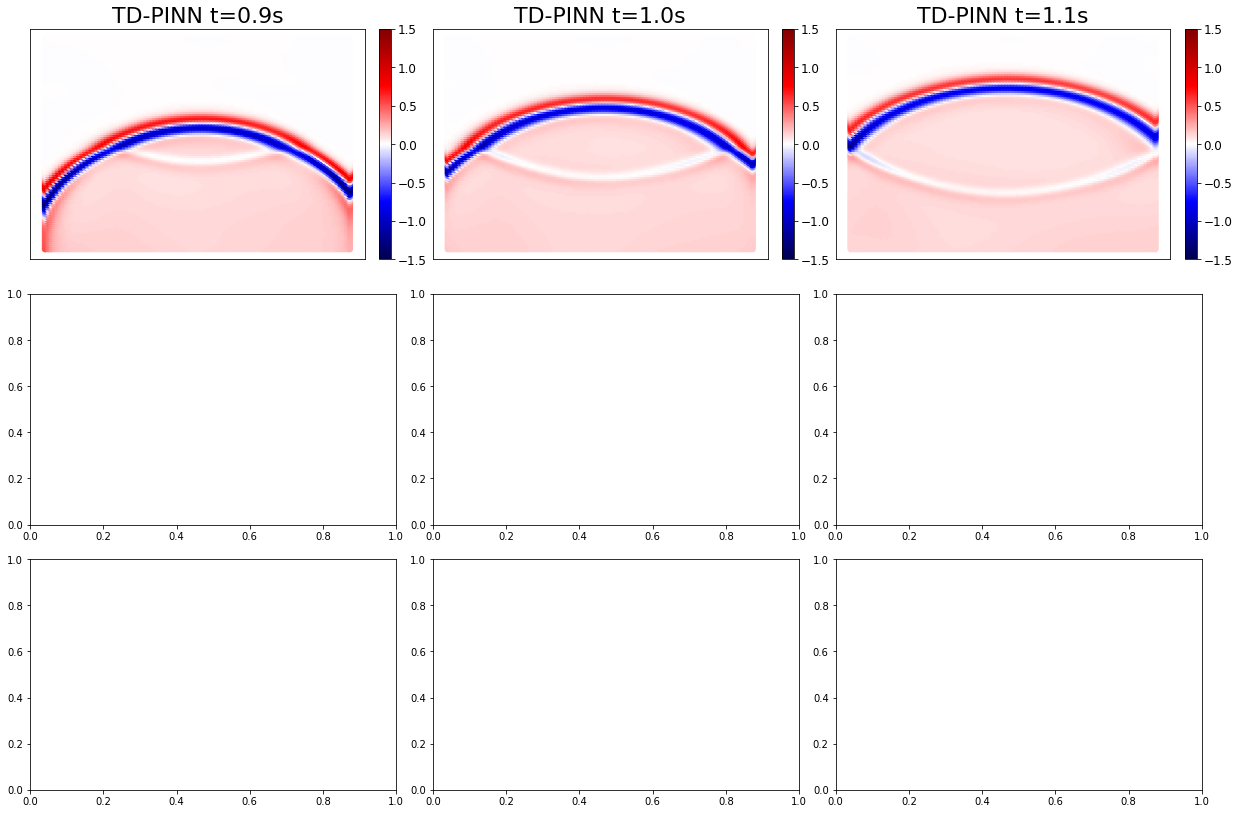

In [3]:
if __name__ == "__main__":

    # Need pretraining!! (i.e. train for 10s -> 15s -> 25s)

    MAX_T = 1.2
    # Domain bounds
    lb = np.array([0.0, 0.0, 0.2])
    ub = np.array([2, 2, MAX_T])
    lb_sam = np.array([0.0, 0.5, 0.5])
    ub_sam = np.array([2, 1.5, MAX_T])

    uv_layers = [3] + 5*[64] + 3*[32]  + [1]

    # Num of collocation point in x, y, t
    N_f = 80000
    
    data_snap1 = scipy.io.loadmat('./ceng_zs0/u_t2.mat')
    data_snap2 = scipy.io.loadmat('./ceng_zs0/u_t4.mat')
    data_snap3 = scipy.io.loadmat('./ceng_zs0/u_t7.mat')
  
    u_snap1 = data_snap1['u_t0'].flatten()[:, None] 
    u_snap2 = data_snap2['u_t0'].flatten()[:, None]
    x_snap1 =  data_snap1['xx'].flatten()[:, None]
    y_snap1 =  data_snap1['zz'].flatten()[:, None]
    x_snap2 =  data_snap2['xx'].flatten()[:, None]
    y_snap2 =  data_snap2['zz'].flatten()[:, None]
    
    u_snap3 = data_snap3['u_t0'].flatten()[:, None] 
    x_snap3 =  data_snap3['xx'].flatten()[:, None]
    y_snap3 =  data_snap3['zz'].flatten()[:, None]
   
    t_snap1 = np.zeros((x_snap1.size, 1))
    t_snap1.fill(0.2)
    t_snap2 = np.zeros((x_snap2.size, 1))
    t_snap2.fill(0.3)
    t_snap3 = np.zeros((x_snap3.size, 1))
    t_snap3.fill(0.7)
    
    snap1 = np.concatenate((x_snap1, y_snap1, t_snap1, u_snap1), 1)
    snap2 = np.concatenate((x_snap2, y_snap2, t_snap2, u_snap2), 1)
    snap3 = np.concatenate((x_snap3, y_snap3, t_snap3, u_snap3), 1)
  
    N = x_snap1.shape[0]
    N_train = round(N/4*4)   
 # Training Data    
    idx = np.random.choice(N, N_train, replace=False)

    snap1_train = snap1[idx,:]
    snap2_train = snap2[idx,:]
  
    # Collocation point
    XYT = lb + (ub - lb) * lhs(3, N_f)
    XYT_c_sam = lb_sam + (ub_sam - lb_sam) * lhs(3, 30000)
    XYT_c = np.concatenate((XYT, XYT_c_sam), 0)
    vp = XYT_c[:,0:1]*0

    A = XYT_c[:,0:1]
    B = XYT_c[:,1:2]    
        
        
    for i in range(len(vp)):
        if B[i]<1:
            vp[i]=1.5
        else:
            vp[i]=1.9

    with tf.device('/device:GPU:0'):

        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        session = tf.Session(config=config)

        ## Load network if networks are provided
        model = DeepHPM(XYT_c, snap1_train, snap2_train, vp, uv_layers, lb, ub, ExistModel=1, modelDir='uv_NN_ceng_3snap_2.pickle')

        loss_snap, loss_f,loss = model.train(iter=60000, batch_num=1)
        model.train_bfgs(batch_num=1)

        model.save_NN('uv_NN_ceng_3snap_2_2snap_lr_1.pickle')

        model.getloss()
        
        loss_f_history = model.loss_f_rec
        scipy.io.savemat('loss_f_history_train.mat',{'loss_f_history':loss_f_history})
        
        loss_snap_history = model.loss_snap_rec
        scipy.io.savemat('loss_snap_history_train.mat',{'loss_snap_history':loss_snap_history})
        
        loss_adam_history = model.loss_rec
        scipy.io.savemat('loss_adam_history.mat',{'loss_adam_history':loss_adam_history})
        
        loss_lbfgs_history = model.train_loss
        scipy.io.savemat('loss_lbfgs_history.mat',{'loss_lbfgs_history':loss_lbfgs_history})
        
        train_losshistory = np.concatenate((model.loss_rec,model.train_loss),0)
        scipy.io.savemat('loss_adam+lbfgs.mat',{'train_losshistory':train_losshistory})

        # Output result at each time step
        x_star = np.linspace(0.0, 2, 101)
        y_star = np.linspace(0.0, 2, 101)
        x_star, y_star = np.meshgrid(x_star, y_star)
        x_star = x_star.flatten()[:, None]
        y_star = y_star.flatten()[:, None]
      
        shutil.rmtree('./output', ignore_errors=True)
        os.makedirs('./output')
        
        t_star_4 = np.zeros((x_star.size, 1))
        t_star_4.fill(0.4)
        u_pred_4 = model.predict(x_star, y_star, t_star_4)
        
        t_star_5 = np.zeros((x_star.size, 1))
        t_star_5.fill(0.5)
        u_pred_5 = model.predict(x_star, y_star, t_star_5)
        
        t_star_6 = np.zeros((x_star.size, 1))
        t_star_6.fill(0.6)
        u_pred_6 = model.predict(x_star, y_star, t_star_6)
        
        t_star_9 = np.zeros((x_star.size, 1))
        t_star_9.fill(0.9)
        u_pred_9 = model.predict(x_star, y_star, t_star_9)
        
        t_star_10 = np.zeros((x_star.size, 1))
        t_star_10.fill(1)
        u_pred_10 = model.predict(x_star, y_star, t_star_10)
        
        t_star_11 = np.zeros((x_star.size, 1))
        t_star_11.fill(1.1)
        u_pred_11 = model.predict(x_star, y_star, t_star_11)
        
    
    scipy.io.savemat('u_pred_4.mat',{'u_pred_4':u_pred_4})
    scipy.io.savemat('u_pred_5.mat',{'u_pred_5':u_pred_5})
    scipy.io.savemat('u_pred_6.mat',{'u_pred_6':u_pred_6})
    
    scipy.io.savemat('u_pred_9.mat',{'u_pred_9':u_pred_9})
    scipy.io.savemat('u_pred_10.mat',{'u_pred_10':u_pred_10})
    
    scipy.io.savemat('u_pred_11.mat',{'u_pred_11':u_pred_11})
   
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(21, 14))
    fig.subplots_adjust(hspace=0.15, wspace=0.1)
    
    uu1=ax[0,0].scatter(x_star, y_star, c=u_pred_9,cmap = ('seismic'),vmin=-1.5, vmax=1.5)
    ax[0, 0].set_xticks([])
    ax[0, 0].set_yticks([])
    ax[0, 0].set_title('TD-PINN t=0.9s', fontsize=22)
    cbar = fig.colorbar(uu1, orientation='vertical', ax=ax[0, 0], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=12)
    #plt.colorbar(uu1)
    
 
    
    uu4=ax[0,1].scatter(x_star, y_star, c=u_pred_10,cmap = ('seismic'),vmin=-1.5, vmax=1.5)
    ax[0, 1].set_xticks([])
    ax[0, 1].set_yticks([])
    ax[0, 1].set_title('TD-PINN t=1.0s', fontsize=22)
    cbar = fig.colorbar(uu4, orientation='vertical', ax=ax[0, 1], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=12)
    
 
    uu7=ax[0,2].scatter(x_star, y_star, c=u_pred_11,cmap = ('seismic'),vmin=-1.5, vmax=1.5)
    ax[0, 2].set_xticks([])
    ax[0, 2].set_yticks([])
    ax[0, 2].set_title('TD-PINN t=1.1s', fontsize=22)
    cbar = fig.colorbar(uu7, orientation='vertical', ax=ax[0, 2], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=12)
    
  
    
    plt.show()

